<a href="https://colab.research.google.com/github/codebluecruz/Getting-started-with-github/blob/master/Submission_4%20actual%20webmd%20LSTM(trained%20%2Btest)_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis w/ Python

This kernel comprise exploratory data analysis on the provided data, including: 
- Data loading
- Data cleaning 
- Descriptive Analysis
- Cleansing Op. on Reviews Column
- Sentiment Analysis
- Importing Models
- Comparing Classifier outputs
- Hyperparameter Optimisation
- Evaluating Results(Accuracy, F1-Score, Roc_auc score, ROC_AUC Cruve)



In [2]:
# Importing major libraries which will be used for our model
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import seaborn as sns
import string
import html
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import spearmanr, pearsonr

# NLTK for Text based analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Environment used for codefile is Google Collaboratory, Here we're mounting our google drive as all our data is saved on drive itself,
# saves us upload time.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading 

Since we're using Google Colab, we'll directly upload our data file from Google Drive.

In [4]:
# Reading data 
drugs = pd.read_csv('/content/drive/My Drive/newset_webmd.csv', skiprows=0)
totrainnlp = pd.read_csv('/content/drive/My Drive/totrainnlp.csv', skiprows=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleansing
Before we perform any operations on our dataset, we need to be very sure of How clean our data is, or else it will not show us actual results.

In [5]:
# droping any NaN rows from our dataset, , ,
drugs = drugs.dropna(how = 'any', axis = 0)
# changing all column names to LowerCase for uniformity
drugs.columns = drugs.columns.str.lower()
drugs.reset_index(drop = True, inplace = True)
drugs['condition'].isnull().sum(axis = 0)
#dropping unnecessary columns
# removing Data columns(Date, Sex, Sides(Side effects)) which doesnt seem to be of much use
drugs.drop(['date', 'sex', 'sides','age'], axis=1, inplace=True)
# Also we're removing all duplicate reviews which appear in our dataset, as every individual must have given unique reviews to all drugs.
drugs = drugs.drop_duplicates(subset=['reviews'], keep='first')

In [6]:
# droping any NaN rows from our dataset, changing all string values to LowerCase, removing Date column as it doesnt seem to be of much use.
totrainnlp = totrainnlp.dropna(how = 'any', axis = 0)
totrainnlp.columns = totrainnlp.columns.str.lower()
totrainnlp.reset_index(drop = True, inplace = True)
totrainnlp['condition'].isnull().sum(axis = 0)
#dropping unnecessary columns
totrainnlp.drop(['date', 'sex', 'sides', 'condition', 'effectiveness', 'easeofuse', 'usefulcount', 'drug', 'drugid', 'age'], axis=1, inplace=True)
totrainnlp = totrainnlp.drop_duplicates(subset=['reviews'], keep='first')

In [7]:
totrainnlp.head(1)

,reviews,satisfaction
0,"I've been on prozac, zoloft and celexa over th...",5


### Resampling Dataset
Here we have performed Data resampling, reason being we have 5 different classes for our dataset, and being a multi class problem it's better if we either Undersample or Oversample(SMOTE) our dataset, so to provide equal number of instances for each class.

**We have performed Undersampling here, reason being dataset remains more closes to original values as it cuts down to the total number of instances present in dataset for any class**

In counter1: It projects number of instances for each class, minimum being 8494 and maximum being 27616
In counter 2: We can see the result of undersamlping our dataset. With equal instances of 8494 for each class.

In [8]:
# example of random undersampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# summarize class distribution in original dataset
print(Counter(drugs['satisfaction']))
# define undersample strategy, "all" metric suggests all classes will be undersampled to the least number of instances for any class.
undersample = RandomUnderSampler(sampling_strategy='all')
# fit and apply the transform
X_over, y_over = undersample.fit_resample(drugs.drop(['satisfaction'], axis=1), drugs['satisfaction'])
# summarize class distribution, we can check the result after Undersamlping.
print(Counter(y_over))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Counter({1.0: 27616, 5.0: 27277, 4.0: 14026, 3.0: 11424, 2.0: 8494})
Counter({1.0: 8494, 2.0: 8494, 3.0: 8494, 4.0: 8494, 5.0: 8494})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Undersamlping was performed with Separately keeping in mind about our features(X_over) and targets(y_over).
drugs=pd.DataFrame(X_over)
drugs1=pd.DataFrame(y_over)

In [10]:
# After we perform Undersampling, system replaces the original column names with Index values, hence we're renaming our columns back to the Original names.
drugs1.rename(columns={0:'satisfaction'}, inplace = True)
drugs1.head(1)

,satisfaction
0,1.0


In [11]:
drugs.rename(columns = {0:'condition', 1:'drug',2:'drugid',3:'easeofuse',4:'effectiveness',5:'reviews', 6:'usefulcount'}, inplace = True)
drugs.head(5)

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount
0,Underactive Thyroid,synthroid,7033,3,1,medication is supposed to reduce fatigue and s...,15
1,Chronic Trouble Sleeping,zolpidem tartrate er,8862,3,2,"For some reason, this particular Ambien CR doe...",5
2,Pain,tramadol hcl er,4398,5,1,"Medication did not last the full 24 hours, onl...",1
3,Reddish Nodules Arranged in a Circle On the Skin,"topicort spray, non-aerosol",5949,5,2,went back to dermatologist with spot on hand-s...,0
4,Other,meloxicam,911,3,1,My friend suffered week long migraine.This pi...,5


In [12]:
# We need to concat our features(X_over) and targets(y_over) back in one dataset named Drugs
drugs = pd.concat([drugs, drugs1], axis = 1)
drugs.shape
drugs.head(1)

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction
0,Underactive Thyroid,synthroid,7033,3,1,medication is supposed to reduce fatigue and s...,15,1.0


In [13]:
# shuffle data to prepare final dataset, coz after resampling our dataset was arranged in 
# ascending order of Target(y_over) values which is a problem for our Model Performance.
drugs=drugs.sample(frac=1)

## Data Glimpse

We are willing to check if this dataset have some corrupted data or non present values. 


In [14]:
# Let's delete all of these corrupted rows
print("Number of Corrupted Reviews: ", len(drugs[drugs.condition.str.contains(" users found this comment helpful.",na=False)]))
drugs = drugs[~drugs.condition.str.contains(" users found this comment helpful.",na=False)]

Number of Corrupted Reviews:  0


In [15]:
# Converting desired columns in float dType.
drugs['easeofuse']=drugs['easeofuse'].astype(float)
drugs['effectiveness']=drugs['effectiveness'].astype(float)
drugs['usefulcount']=drugs['usefulcount'].astype(float)
drugs['drugid']=drugs['drugid'].astype(float)
drugs['satisfaction']=drugs['satisfaction'].astype(float)

In [16]:
drugs.describe()

,drugid,easeofuse,effectiveness,usefulcount,satisfaction
count,42470.000000,42470.000000,42470.000000,42470.000000,42470.00000
mean,46546.571227,4.019425,3.541559,6.956722,3.00000
std,58515.646694,1.261692,1.351659,8.970967,1.41423
min,1.000000,1.000000,1.000000,0.000000,1.00000
25%,6007.000000,3.000000,3.000000,1.000000,2.00000
50%,13028.000000,5.000000,4.000000,4.000000,3.00000
75%,78136.000000,5.000000,5.000000,9.000000,4.00000
max,177760.000000,5.000000,5.000000,178.000000,5.00000


In [17]:
### Thought flow for Depression Confidence Intervals
"""
I want to take the df, filter by condition, drug, confidence interval, sample size cutoff)
Then loop through all the drugs for a specific condition and calculate their
mean, top limit, and bottom limit. 
"""
# Create Confidence Interval Function
def confidence_interval (data, ci_percent):
  data = np.array(data) # Makes sure our data is in a numpy array
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + ci_percent) / 2., n - 1)
  return (mean, mean - interval, mean + interval)


def condition_compare (drugs, condition_id, ci_percent, sample_size_cutoff):
  output_names = ["Drug Name", "Sample Mean", "Lower Bound", "Upper Bound", "Sample Size"]
  drug_compare = []
  data = drugs[drugs.condition == condition_id]
  for drug in data.drug.unique():
    one_drug = data[data.drug == drug].satisfaction
    if one_drug.size > sample_size_cutoff:
      mean, ilower, iupper= confidence_interval(one_drug, ci_percent)
      entry = [drug, mean, ilower, iupper, one_drug.size]
      drug_compare.append(entry)
  return pd.DataFrame(drug_compare, columns=output_names)

# COndition passed on here by us is "Cough".
drugs2 = condition_compare(drugs, "Cough", 0.95, 10).sort_values(by="Sample Mean", ascending=False)
drugs2

,Drug Name,Sample Mean,Lower Bound,Upper Bound,Sample Size
0,tussionex,4.062500,3.643467,4.481533,32
3,tessalon perle,3.318966,3.016425,3.621506,116
4,promethazine-codeine,3.200000,2.439540,3.960460,15
2,virtussin ac,3.000000,2.109462,3.890538,17
1,promethazine-dm,2.894737,2.215104,3.574370,19


In [18]:
#We have created a column named "uniqueid" for every row, to easen up our operations.
drugs['uniqueid'] = np.arange(len(drugs))
drugs.head()

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid
32079,Seasonal Runny Nose,zyrtec,12127.0,5.0,5.0,The best thing EVER for me. It took two days o...,0.0,4.0,0
3536,Depression,pristiq,150251.0,5.0,1.0,This was prescribed to my by a NP who felt tha...,10.0,1.0,1
16225,Condition in which Stomach Acid is Pushed Into...,pantoprazole sodium,17633.0,4.0,4.0,I have taken pantoprazole for over on month an...,22.0,2.0,2
40613,Weight Gain,phentermine hcl,4151.0,5.0,5.0,I found this medication VERY effective. I was...,1.0,5.0,3
5486,Allergic Reaction caused by a Drug,"prednisone tablet, delayed release (enteric co...",6007.0,2.0,1.0,"Rapid heart beat, stomach issues, nervousness,...",0.0,1.0,4


In [19]:
# We will use this groupings later on for Descriptive analysis...

print("Number of Reviews per Drug")
# Number of reviews per drug
reviews_per_drug = drugs.groupby(["drug"]).agg({
    "uniqueid": pd.Series.nunique
})
reviews_per_drug.describe()


print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "uniqueid": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Drug
Number of Reviews per Condition


,uniqueid
count,942.000000
mean,45.084926
std,257.965298
min,1.000000
25%,1.000000
50%,5.000000
75%,18.000000
max,6066.000000


In [20]:
# Conerting all reviews in our dataset, to lower case. for uniformity.
drugs['reviews'] = drugs['reviews'].str.lower()
drugs.head(5)

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid
32079,Seasonal Runny Nose,zyrtec,12127.0,5.0,5.0,the best thing ever for me. it took two days o...,0.0,4.0,0
3536,Depression,pristiq,150251.0,5.0,1.0,this was prescribed to my by a np who felt tha...,10.0,1.0,1
16225,Condition in which Stomach Acid is Pushed Into...,pantoprazole sodium,17633.0,4.0,4.0,i have taken pantoprazole for over on month an...,22.0,2.0,2
40613,Weight Gain,phentermine hcl,4151.0,5.0,5.0,i found this medication very effective. i was...,1.0,5.0,3
5486,Allergic Reaction caused by a Drug,"prednisone tablet, delayed release (enteric co...",6007.0,2.0,1.0,"rapid heart beat, stomach issues, nervousness,...",0.0,1.0,4


## Descriptive Analysis


### Top 10 Reviewed Drugs

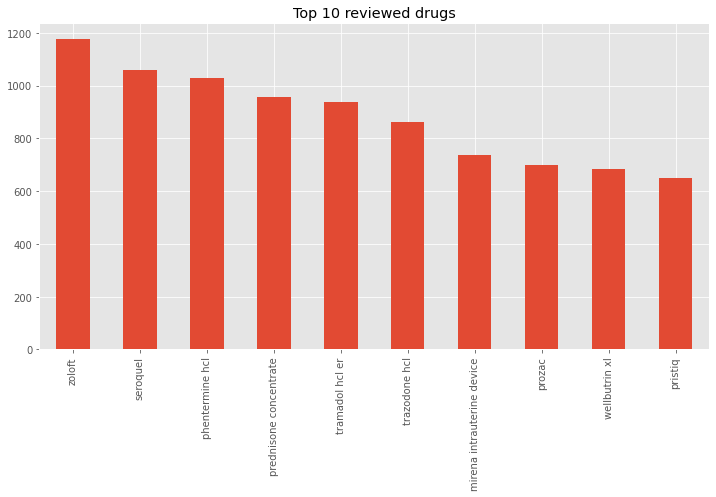

In [21]:
# Top 10 most reviewed drug names
plot = drugs.drug.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))

### Top 10 conditions undergoing by drug reviewers

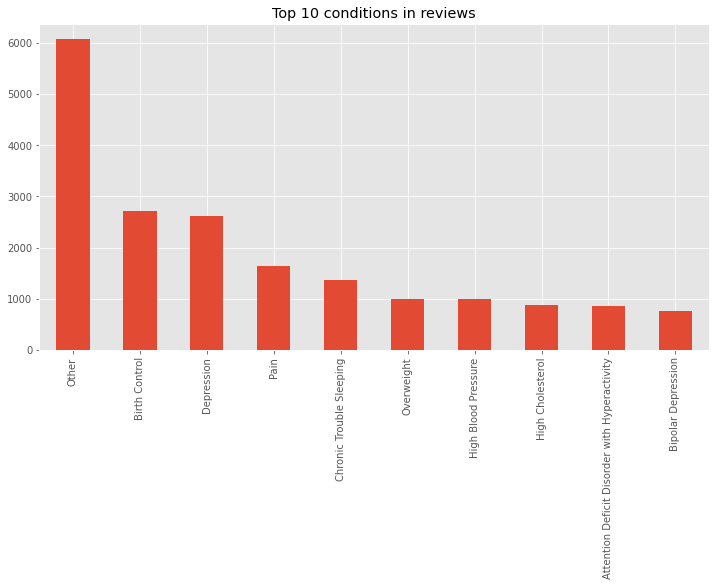

In [22]:
# Top 10 most suffered condition by reviewers
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

### Top 10 drugs with best and worst rating

When doing this analysis for all the drugs, there is a factor which affect the results: **the number of reviews of a drug**. I.e. if we want to compute the drug with best rating, the drug which in **only 1 review** was given a 10 rating would be in TOP 1. For this reason, we only consider drugs with a significant number of reviews. **A significant number of reviews is when the number of reviews for a drug is above the 75% of the number of reviews distribution per drug.**


Significant number of reviews: More than 14.0 reviews


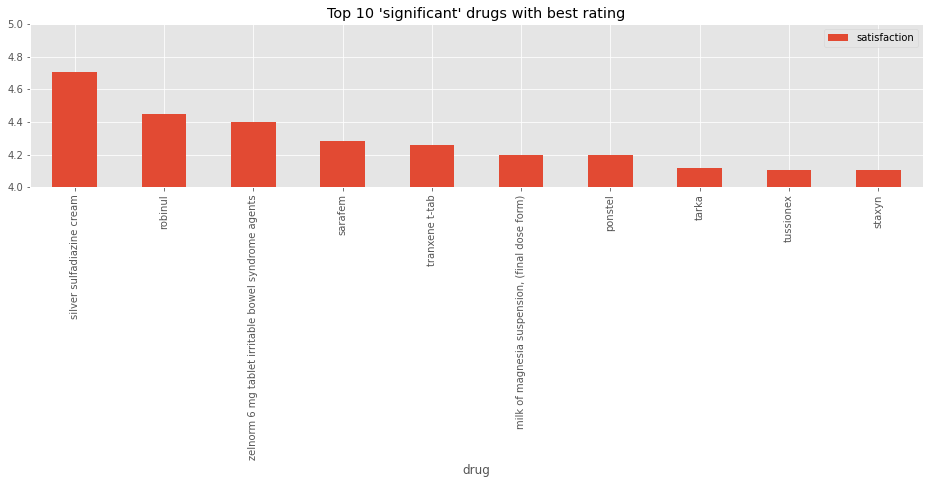

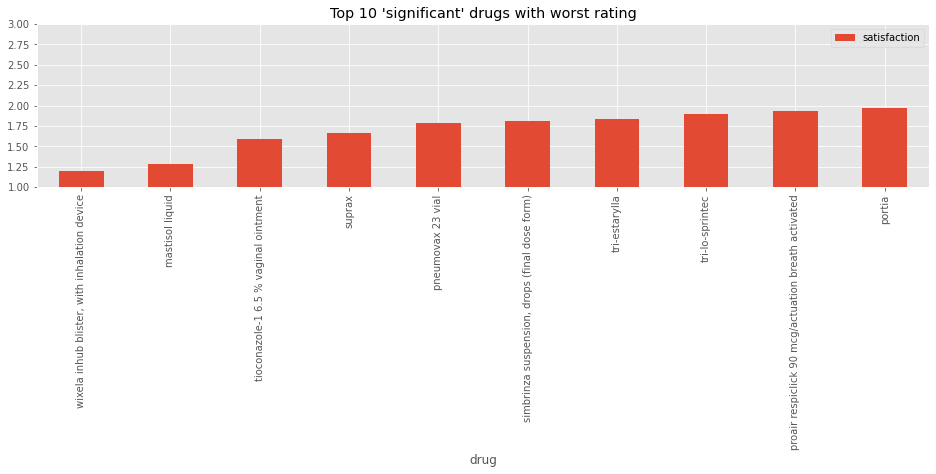

In [23]:
drugs_rating = drugs.groupby('drug').agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Significant number of reviews: More than", reviews_per_drug.quantile(q=0.75).values[0], "reviews")

# We only use the drugs which number of reviews is higher than a threshold
drugs_rating = drugs_rating[drugs_rating['uniqueid'] > int(reviews_per_drug.quantile(q=0.75))]

# Top 10
top_drugs_rating = drugs_rating.nlargest(10, 'satisfaction')
plot = top_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

# Bottom 10
bottom_drugs_rating = drugs_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

### Analyzing Pairs (Drug, Condition) with best and worst ratings

We theorize that the rating of a drug, is strongly related to the condition that the person who reviewed was suffering. We are going to compute the top 10 best and worst rating of reviews for (Drug, condition) pairs.

Number of pairs (Drug, Condition): 4238
Significant number of reviews: More than 7.0 reviews


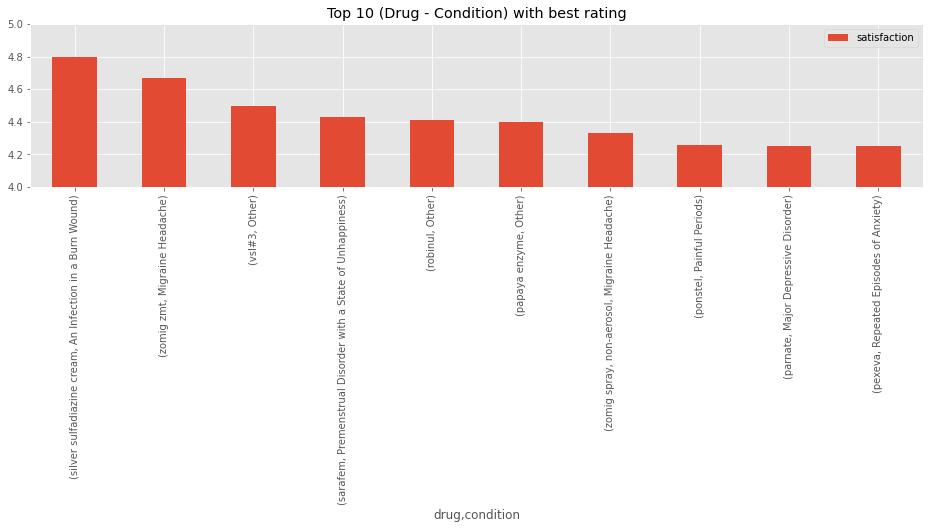

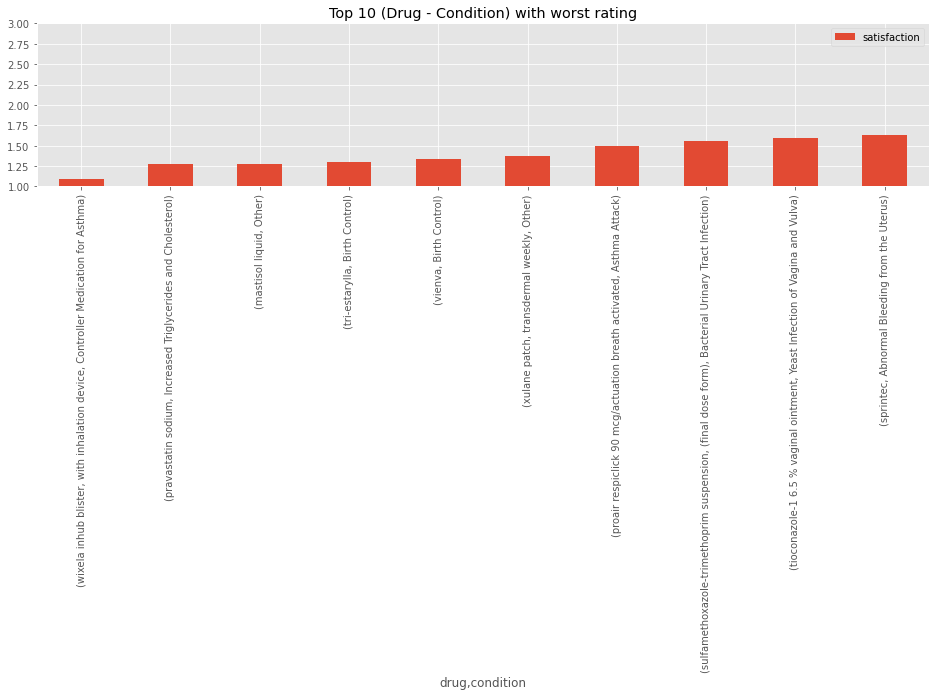

In [24]:
drugs_condition_rating = drugs.groupby(['drug', 'condition']).agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Number of pairs (Drug, Condition):", len(drugs_condition_rating))

print("Significant number of reviews: More than", drugs_condition_rating['uniqueid'].quantile(q=0.75), "reviews")

drugs_condition_rating = drugs_condition_rating[drugs_condition_rating['uniqueid'] > int(drugs_condition_rating['uniqueid'].quantile(q=0.75))]
# drugs_condition_rating.sort_values('rating', ascending=False)
top_drugs_condition_rating = drugs_condition_rating.nlargest(10, 'satisfaction')
plot = top_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

bottom_drugs_condition_rating = drugs_condition_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

## Cleansing Op. on Reviews Column


In [25]:
# Function to perform cleansing operations on our Text column
def clean_reviews(reviews):
    
    ## Remove puncuation
    reviews = reviews.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    reviews = reviews.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    reviews = [w for w in reviews if not w in stops and len(w) >= 3]
    
    reviews = " ".join(reviews)

    # Clean the reviews
    reviews = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", reviews)
    reviews = re.sub(r"what's", "what is ", reviews)
    reviews = re.sub(r"\'s", " ", reviews)
    reviews = re.sub(r"\'ve", " have ", reviews)
    reviews = re.sub(r"n't", " not ", reviews)
    reviews = re.sub(r"i'm", "i am ", reviews)
    reviews = re.sub(r"\'re", " are ", reviews)
    reviews = re.sub(r"\'d", " would ", reviews)
    reviews = re.sub(r"\'ll", " will ", reviews)
    reviews = re.sub(r",", " ", reviews)
    reviews = re.sub(r"\.", " ", reviews)
    reviews = re.sub(r"!", " ! ", reviews)
    reviews = re.sub(r"\/", " ", reviews)
    reviews = re.sub(r"\^", " ^ ", reviews)
    reviews = re.sub(r"\+", " + ", reviews)
    reviews = re.sub(r"\-", " - ", reviews)
    reviews = re.sub(r"\=", " = ", reviews)
    reviews = re.sub(r"'", " ", reviews)
    reviews = re.sub(r"(\d+)(k)", r"\g<1>000", reviews)
    reviews = re.sub(r":", " : ", reviews)
    reviews = re.sub(r" e g ", " eg ", reviews)
    reviews = re.sub(r" b g ", " bg ", reviews)
    reviews = re.sub(r" u s ", " american ", reviews)
    reviews = re.sub(r"\0s", "0", reviews)
    reviews = re.sub(r" 9 11 ", "911", reviews)
    reviews = re.sub(r"e - mail", "email", reviews)
    reviews = re.sub(r"j k", "jk", reviews)
    reviews = re.sub(r"\s{2,}", " ", reviews)
    
    reviews = reviews.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in reviews]
    reviews = " ".join(stemmed_words)

    return reviews

In [26]:
drugs['reviews_clean'] = drugs['reviews'].map(lambda x: clean_reviews(x))

In [27]:
drugs.shape

(42470, 10)

In [28]:
# We have made a copy of our original dataset, for just in case.
drugs_copy=drugs

## Sentiment Analysis

Before doing this, **text** must be processed:

- Punctuation signs are removed already in last step.
- Removing special characters
- Stemming
- Removing Stopwords

Although a RNN can learn dependencies however, it can only learn about recent information. LSTM can help solve this problem as it can understand context along with recent dependency. Hence, LSTM are a special kind of RNN where understanding context can help to be useful.
LSTM networks are similar to RNNs with one major difference that hidden layer updates are replaced by memory cells. This makes them better at finding and exposing long range dependencies in data which is imperative for sentence structures. Image below shows a representation of LSTM sequence tagging model which has LSTM memory cells in place of hidden layers.
-NLTK was the library used in this code file. With BeautifulSoup and Tensorflow.
To transform each review into relevant rating for the drug, firstly NLP was performed on review columns only, separating it from the metadata.
This contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:
1 - negative
2 - somewhat negative
3 - neutral
4 - somewhat positive
5 - positive


CNN LSTM
- We're now trying to improve our operations on Reviews column using CNN+LSTM, the reason being, LSTM takes into consideration the sequences of our model in its Cell State, which is really important for any Text Data, coz it gives meaning to it.
- "I Love Dogs" in this sequence is meaningful but "Dog Love I" sounds confusing. than again with longer text size, the sequences or order becomes more important.
- We'll be using embedding layer for Word Embeddings, which helps us to see semantics or meaning behind "Reviews", being positive or negative.
- Tokeniser helps in encoding our data
- We have padded our Reviews accordingly, considering the maximum length of a Review.

## LSTM Implementation

In [29]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import tensorflow as tf
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from tqdm import tqdm
nltk.download('punkt') ## added for GoogleCollab
nltk.download('wordnet') ## added for GoogleCollab

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
train_sentences = drugs['reviews'].map(lambda x: clean_reviews(x))
train_sentences1 = totrainnlp['reviews'].map(lambda x: clean_reviews(x))

In [31]:
def clean_sentences(reviews):
    reviews = []

    for sent in tqdm(train_sentences):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [32]:
def clean_sentences1(reviews):
    reviews = []

    for sent in tqdm(train_sentences1):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)


In [33]:
train_sentences = clean_sentences(train_sentences)
train_sentences1 = clean_sentences1(train_sentences1)

100%|██████████| 103148/103148 [01:04<00:00, 1590.26it/s]


In [34]:
# Here we're trying to find the maximum length of any reviews given by Patient
# Which will help us in padding our reviews in LSTM model.
unique_words = set()
len_max = 0

for sent in tqdm(train_sentences):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 42470/42470 [00:00<00:00, 411793.74it/s]

27017
239


In [35]:
unique_words1 = set()
len_max1 = 0

for sent in tqdm(train_sentences1):
    
    unique_words1.update(sent)
    
    if(len_max1<len(sent)):
        len_max1 = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words1)))
print(len_max1)

100%|██████████| 103148/103148 [00:00<00:00, 416210.01it/s]

43941
255


In [36]:
# oov_tok replaces unknown words with "<OOV>" as a value
# incase truncating is requirred out model will do so behind the text rows.
trunc_type='post'
oov_tok="<OOV>"
tokenizer1 = Tokenizer(num_words= len(list(unique_words1)), oov_token=oov_tok)
tokenizer1.fit_on_texts(train_sentences1)

sequences1 = tokenizer1.texts_to_sequences(train_sentences1)
data1 = pad_sequences(sequences1, maxlen=len_max, truncating=trunc_type)

In [37]:
# Early stopping incase scores doesnt change aroung cycles.
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_auc', patience = 2)
callback = [early_stopping]

In [38]:
from keras.utils import to_categorical
y_target=to_categorical(totrainnlp['satisfaction'])
num_classes=y_target.shape[1]

In [39]:
num_classes

6

In [40]:
# we have used one LSTM layer for our operations, with a combination of a CNN Layer coz it really speeds up our task,
# further Maxpooling helps in reducing the problem of high dimensionality coz LSTM would usually return 2D array.
# Sigmoid activator is used coz we have binary(0/1) semantics for our reviews
# Two layer LSTM can also be implmented(with return sequence "True" meaning the feedback cycle will be used) but 
# for now i have commented them out.

def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(len(list(unique_words1)), 300, input_length=len_max))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(256, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(128))
    
    model_conv.add(Dense(num_classes, activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=[tf.keras.metrics.AUC()])
    model_conv.summary()
    return model_conv

In [41]:
model_conv = create_conv_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 239, 300)          13182300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 239, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 235, 256)          384256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 58, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 13,764,450
Trainable params: 13,764,450
Non-trainable params: 0
__________________________________________

In [42]:
history =model_conv.fit(data1, y_target, validation_split=0.4, epochs = 2, callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 61888 samples, validate on 41260 samples
Epoch 1/2
61888/61888 [==============================] - 388s 6ms/step - loss: 1.3192 - auc: 0.7825 - val_loss: 1.2485 - val_auc: 0.8141
Epoch 2/2
61888/61888 [==============================] - 392s 6ms/step - loss: 1.1691 - auc: 0.8266 - val_loss: 1.2649 - val_auc: 0.8320


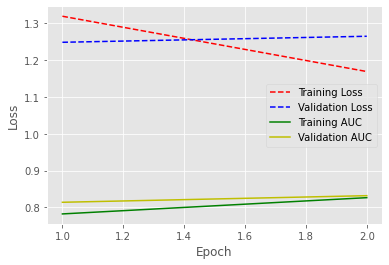

In [43]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b--')
plt.plot(epoch_count, history.history['auc'], 'g-')
plt.plot(epoch_count, history.history['val_auc'], 'y-')
plt.legend(['Training Loss', 'Validation Loss', 'Training AUC', 'Validation AUC'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
# Predicting target values for Training dataset
nlp_pred1=model_conv.predict_classes(data1)

In [45]:
lstm_op1=pd.DataFrame(nlp_pred1)
df_target=pd.DataFrame(y_target)

df_target=df_target.idxmax(axis=1)
df_target=pd.DataFrame(df_target)
df_target

,0
0,5
1,2
2,4
3,2
4,1
...,...
103143,5
103144,1
103145,2
103146,5


In [46]:
lstm_op1

,0
0,5
1,1
2,5
3,5
4,1
...,...
103143,1
103144,1
103145,1
103146,5


In [56]:
# ROC score between Target and predicted values for Trained dataset
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(df_target)
y_test1 = lb.transform(df_target)
y_pred1= lb.transform(lstm_op1)
roc_auc_score_trainset=roc_auc_score(y_test1, y_pred1, average="macro")
roc_auc_score_trainset

0.6396263461430765

### LSTM Test dataset

In [48]:
tokenizer = Tokenizer(num_words= len(list(unique_words1)), oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

sequences = tokenizer.texts_to_sequences(train_sentences)
data = pad_sequences(sequences, maxlen=len_max, truncating=trunc_type)

In [49]:
# # Predicting target values for Test dataset "Drugs" which is our main/core dataset
nlp_pred=model_conv.predict_classes(data)

In [50]:
lstm_op=pd.DataFrame(nlp_pred)
lstm_op

,0
0,5
1,5
2,1
3,5
4,5
...,...
42465,1
42466,1
42467,5
42468,1


In [51]:
y_target1=to_categorical(drugs['satisfaction'])
df_target1=pd.DataFrame(y_target1)
df_target1=df_target1.idxmax(axis=1)
df_target1=pd.DataFrame(df_target1)
df_target1

,0
0,4
1,1
2,2
3,5
4,1
...,...
42465,5
42466,5
42467,3
42468,3


In [59]:
# ROC score between Target and predicted values for Test dataset "Drugs"
lb.fit(df_target1)
y_test1 = lb.transform(df_target1)
y_pred1= lb.transform(lstm_op)
roc_auc_score_testset=roc_auc_score(y_test1, y_pred1, average="macro")
roc_auc_score_testset

0.5019719802213327

In [63]:
lstm_op.rename(columns = {0:'lstm_score'}, inplace = True)
lstm_op

,lstm_score
0,5
1,5
2,1
3,5
4,5
...,...
42465,1
42466,1
42467,5
42468,1


In [64]:
drugs = pd.concat([drugs_copy.reset_index(), lstm_op.reset_index()], axis = 1)

In [65]:
drugs.drop(['index'], axis=1, inplace=True)
drugs.head(1)

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid,reviews_clean,lstm_score
0,Seasonal Runny Nose,zyrtec,12127.0,5.0,5.0,the best thing ever for me. it took two days o...,0.0,4.0,0,best thing ever me took two day use otc kick t...,5


## Feature Engineering
We're trying to extract more information from "Reviews" column via Feature engineering process. Further we'll optimise the use of these features accordingly depending upon the **Importance and Feature Selection process**

In [66]:
#Word count in each review
drugs['count_word']=drugs["reviews_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
drugs['count_unique_word']=drugs["reviews_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
drugs['count_letters']=drugs["reviews_clean"].apply(lambda x: len(str(x)))

#punctuation count
drugs["count_punctuations"] = drugs["reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


#Number of stopwords
stops = set(stopwords.words("english"))
drugs["count_stopwords"] = drugs["reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
drugs["mean_word_len"] = drugs["reviews_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [67]:
# Label Encoding Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['condition']:
    label_encoder_feat[feature] = LabelEncoder()
    drugs[feature] = label_encoder_feat[feature].fit_transform(drugs[feature])

In [68]:
corr=drugs.corr(method ='pearson')

In [69]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,condition,drugid,easeofuse,effectiveness,usefulcount,satisfaction,uniqueid,lstm_score,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len
condition,1.00,-0.11,-0.03,-0.04,-0.01,0.04,0.00,0.02,-0.05,-0.06,-0.05,-0.05,-0.06,0.00
drugid,-0.11,1.00,-0.05,-0.03,0.03,-0.05,-0.01,-0.02,0.09,0.09,0.09,0.07,0.09,-0.00
easeofuse,-0.03,-0.05,1.00,0.49,0.05,0.50,0.01,0.00,0.00,0.01,0.00,0.01,0.02,-0.01
effectiveness,-0.04,-0.03,0.49,1.00,0.06,0.73,0.01,-0.00,0.07,0.08,0.07,0.06,0.08,-0.00
usefulcount,-0.01,0.03,0.05,0.06,1.00,0.07,0.01,-0.04,0.19,0.20,0.20,0.17,0.18,-0.00
satisfaction,0.04,-0.05,0.50,0.73,0.07,1.00,0.00,0.02,-0.02,-0.02,-0.02,-0.02,-0.01,0.00
uniqueid,0.00,-0.01,0.01,0.01,0.01,0.00,1.00,0.01,0.00,-0.00,0.00,-0.00,0.00,0.00
lstm_score,0.02,-0.02,0.00,-0.00,-0.04,0.02,0.01,1.00,-0.09,-0.10,-0.09,-0.07,-0.08,0.00
count_word,-0.05,0.09,0.00,0.07,0.19,-0.02,0.00,-0.09,1.00,0.99,0.99,0.86,0.94,-0.01
count_unique_word,-0.06,0.09,0.01,0.08,0.20,-0.02,-0.00,-0.10,0.99,1.00,0.99,0.85,0.94,-0.01


In [70]:
drugs = drugs.dropna(how = 'any', axis = 0)

In [71]:
# Final check for any Nan Values in Pre-processed Dataset.
drugs.isna().sum()

condition             0
drug                  0
drugid                0
easeofuse             0
effectiveness         0
reviews               0
usefulcount           0
satisfaction          0
uniqueid              0
reviews_clean         0
lstm_score            0
count_word            0
count_unique_word     0
count_letters         0
count_punctuations    0
count_stopwords       0
mean_word_len         0
dtype: int64

In [72]:
drugs.dtypes

condition               int64
drug                   object
drugid                float64
easeofuse             float64
effectiveness         float64
reviews                object
usefulcount           float64
satisfaction          float64
uniqueid                int64
reviews_clean          object
lstm_score              int64
count_word              int64
count_unique_word       int64
count_letters           int64
count_punctuations      int64
count_stopwords         int64
mean_word_len         float64
dtype: object

In [73]:
drugs.head(1)

,condition,drug,drugid,easeofuse,effectiveness,reviews,usefulcount,satisfaction,uniqueid,reviews_clean,lstm_score,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len
0,755,zyrtec,12127.0,5.0,5.0,the best thing ever for me. it took two days o...,0.0,4.0,0,best thing ever me took two day use otc kick t...,5,41,33,231,11,41,4.658537


# Importing Libraries for the Machine Learning Model


In [74]:
# Importing Libraries for the Machine Learning Model
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [75]:
# Almost Equal number of instances for all classes in Target Column.
drugs['satisfaction'].value_counts()

1.0    8492
4.0    8492
2.0    8491
5.0    8490
3.0    8486
Name: satisfaction, dtype: int64

In [76]:
# Defining Features/target and splitting the data as train and test set with 30% split ratio.
features = drugs[[ 'effectiveness', 'lstm_score', 'easeofuse', 'condition', 'count_letters',
                   ]]

target = drugs['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (29715, 5)
The Test set size  (12736, 5)


#### Firstly we'll try and check which classifier performs the best with our training data, then we'll take that classifier and perform HyperParameter Optimisation on that model.

In [77]:
# Implementing Different Classifier(), step by step
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
precision_score_knn=precision_score(y_test, preds, average='micro')

# We are using LabelBinarizer() coz, we need to compare results for multi-class problem, so with this function we Binarize class 
# output results and compare it with binarized target values, it helps us to check ROC for our problem.
lb = LabelBinarizer()
lb.fit(y_test)
y_test1 = lb.transform(y_test)
y_pred1= lb.transform(preds)
roc_auc_score_knn=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_knn))
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))
print("Precision on test dataset:", precision_score_knn)

Roc_auc_score for test data: 0.56533 
Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 30.43
Time consumed for training: 0.036 seconds
Time consumed for prediction: 0.37252 seconds
Precision on test dataset: 0.30433417085427134


In [78]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
precision_score_gbk=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_gbk=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_gbk))
print("Scikit-Learn's GBK Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))
print("Precision on test dataset:", precision_score_gbk)

Roc_auc_score for test data: 0.73752 
Scikit-Learn's GBK Classifier's prediction accuracy is: 58.01
Time consumed for training: 14.815 seconds
Time consumed for prediction: 0.11569 seconds
Precision on test dataset: 0.5800879396984925


In [79]:
GNB= GaussianNB()
training_start = time.perf_counter()
GNB.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = GNB.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
precision_score_gnb=precision_score(y_test, preds, average='micro')
y_pred1= lb.transform(preds)
roc_auc_score_gnb=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_gnb))
print("Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))
print("Precision on test dataset:", precision_score_gnb)

Roc_auc_score for test data: 0.72509 
Naive Bayes Classifier's prediction accuracy is: 56.01
Time consumed for training: 0.009 seconds
Time consumed for prediction: 0.00410 seconds
Precision on test dataset: 0.5600659547738693


In [80]:
LGBM = LGBMClassifier()
training_start = time.perf_counter()
LGBM.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LGBM.predict(X_test)
prediction_end = time.perf_counter()
acc_LGBM = (preds == y_test).sum().astype(float) / len(preds)*100
LGBM_train_time = training_end-training_start
LGBM_prediction_time = prediction_end-prediction_start
precision_score_lgbm=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_lgbm=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_lgbm))
print("Scikit-Learn's LGBM Classifier's prediction accuracy is: %3.2f" % (acc_LGBM))
print("Time consumed for training: %4.3f seconds" % (LGBM_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LGBM_prediction_time))
print("Precision on test dataset:", precision_score_lgbm)


Roc_auc_score for test data: 0.73730 
Scikit-Learn's LGBM Classifier's prediction accuracy is: 57.96
Time consumed for training: 1.351 seconds
Time consumed for prediction: 0.01741 seconds
Precision on test dataset: 0.5796168341708543


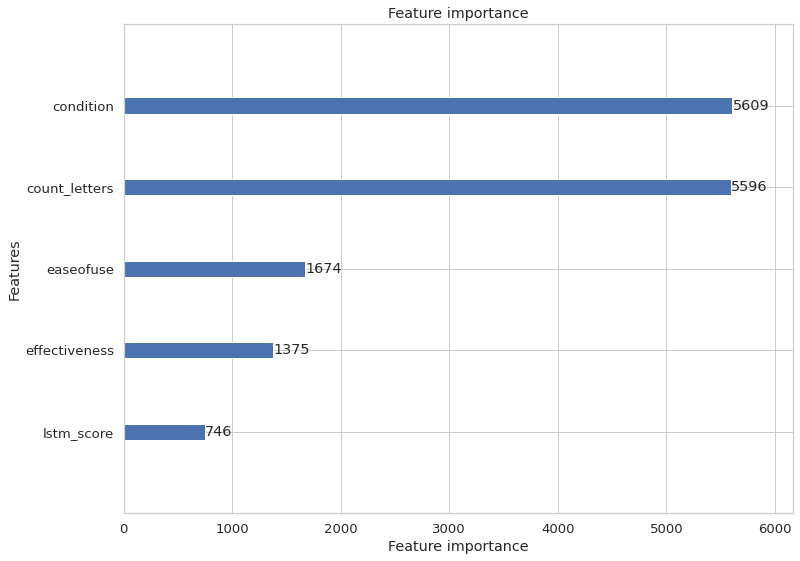

In [81]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(LGBM);

In [82]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
precision_score_LR=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_LR=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_LR))
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))
print("Precision on test dataset:", precision_score_LR)


Roc_auc_score for test data: 0.59863 
Scikit-Learn's LR Classifier's prediction accuracy is: 35.76
Time consumed for training: 2.361 seconds
Time consumed for prediction: 0.00300 seconds
Precision on test dataset: 0.3576476130653266


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
from sklearn.ensemble import RandomForestClassifier
import time

rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
precision_score_rfc=precision_score(y_test, preds, average='micro')

y_pred1= lb.transform(preds)
roc_auc_score_rfc=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))
print("Precision on test dataset:", precision_score_rfc)

Roc_auc_score for test data: 0.68299 
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 49.25
Time consumed for training: 0.419 seconds
Time consumed for prediction: 0.04342 seconds
Precision on test dataset: 0.49246231155778897


In [84]:
#After running all classifier models individually, we compare them all together for best performance
results = pd.DataFrame({
    'Model': ['KNN', 'GNB', 'LGBM', 'gbk', 'LR', 'Random Forest'],
    'Roc_auc_score': [roc_auc_score_knn, roc_auc_score_gnb, roc_auc_score_lgbm, roc_auc_score_gbk, roc_auc_score_LR, roc_auc_score_rfc],
    'Accuracy': [acc_knn, acc_gnb, acc_LGBM, acc_gbk, acc_LR, acc_rfc],
    'Precision': [precision_score_knn, precision_score_gnb, precision_score_lgbm, precision_score_gbk, precision_score_LR, precision_score_rfc],
    'Runtime Training': [knn_train_time, gnb_train_time, LGBM_train_time, gbk_train_time, 
                         LR_train_time, rfc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, LGBM_prediction_time, gbk_prediction_time,
                          LR_prediction_time, rfc_prediction_time]})
result_df = results.sort_values(by='Roc_auc_score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Roc_auc_score,Accuracy,Precision,Runtime Training,Runtime Prediction
Model,,,,,
gbk,0.737523,58.008794,0.580088,14.814665,0.115685
LGBM,0.737302,57.961683,0.579617,1.350911,0.017408
GNB,0.725088,56.006595,0.560066,0.009232,0.004096
Random Forest,0.682987,49.246231,0.492462,0.419017,0.043423
LR,0.598632,35.764761,0.357648,2.361178,0.003003
KNN,0.565329,30.433417,0.304334,0.035975,0.372516


In [85]:
from sklearn.model_selection import cross_validate
gbk_cv = GradientBoostingClassifier(n_estimators=10)
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
scores = cross_validate(gbk_cv, X_train, y_train, cv=3, scoring = scoring)
print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: {'fit_time': array([1.02516794, 1.03702354, 1.03617573]), 'score_time': array([0.03096819, 0.03078341, 0.03136373]), 'test_acc': array([0.57758708, 0.58011106, 0.58253407]), 'test_prec_macro': array([0.59052905, 0.59401628, 0.59403913]), 'test_rec_micro': array([0.57768452, 0.58014421, 0.58259809])}


In [86]:
importances = pd.DataFrame({
    #'Feature': dTreated.drop('Satisfaction', axis=1).columns,
    'Feature': features.columns,
    'Importance': gbk.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=True)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
lstm_score,0.001373
count_letters,0.026286
condition,0.043998
easeofuse,0.100030
effectiveness,0.828313


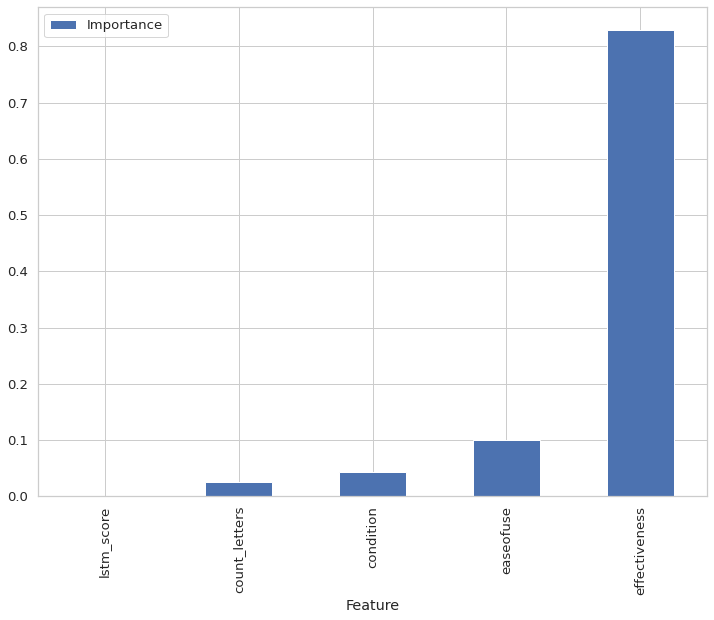

In [87]:
importances.plot.bar()

# Hyperparameter Tuning

In [88]:
from pprint import pprint
# Look at parameters used by our best classifier
print('Parameters currently in use:\n')
pprint(gbk.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [89]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in GradientBoostingClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 19, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
learning_rate = [0.001, 0.07, 0.1, 0.2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': [0.001, 0.07, 0.1, 0.2],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}


In [90]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
gbk_random = RandomizedSearchCV(estimator = gbk, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gbk_random.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  7.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [91]:
# Best parameter values, with best score of accuracy using Hyperparameter tuning
gbk_random.best_params_,gbk_random.best_score_

({'learning_rate': 0.1,
  'max_depth': 7,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.553525155645297)

In [92]:
#implementing hyperopt tuning with set parameter values
GBoost = GradientBoostingClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400, learning_rate=0.07)
#max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=400, learning_rate=0.07

GBoost.fit(X_train, y_train)
preds = GBoost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

y_pred1= lb.transform(preds)
roc_auc_score_gbk=roc_auc_score(y_test1, y_pred1, average="macro")
print("Roc_auc_score for test data: %3.5f " % (roc_auc_score_gbk))

print("Gradient Boost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

Roc_auc_score for test data: 0.73707 
Gradient Boost's prediction accuracy WITH optimal hyperparameters is: 57.92


In [93]:
scores = cross_validate(GBoost, X_train, y_train, cv=3, scoring = scoring)
print("Scores:", scores)

Scores: {'fit_time': array([40.07200146, 41.14840794, 39.85198474]), 'score_time': array([0.29024053, 0.2876966 , 0.28272367]), 'test_acc': array([0.57405351, 0.57809187, 0.58101969]), 'test_prec_macro': array([0.57897567, 0.58176333, 0.58564209]), 'test_rec_micro': array([0.57401888, 0.5780158 , 0.58091099])}


In [94]:
confusion_matrix(preds, y_test)

array([[1628,  230,   71,    8,   12],
       [ 472,  998,  471,  108,   38],
       [ 174,  677, 1034,  243,   35],
       [ 139,  381,  688, 1605,  370],
       [ 117,  214,  351,  560, 2112]])

In [95]:
from sklearn.metrics import recall_score, f1_score
print("Precision on test dataset:", precision_score(y_test, preds, average='micro'))
print("Recall on test dataset:",recall_score(y_test, preds, average='micro'))
print("F1-Score on test dataset:", f1_score(y_test, preds, average='micro'))

Precision on test dataset: 0.5792242462311558
Recall on test dataset: 0.5792242462311558
F1-Score on test dataset: 0.5792242462311558


In [96]:
# Classification report
import sklearn.metrics as metrics
print('\t\t\t\tCLASSIFICATIION METRICS \n \t\t\tfor test dataset\n')
print(metrics.classification_report(y_test, preds))

				CLASSIFICATIION METRICS 
 			for test dataset

              precision    recall  f1-score   support

         1.0       0.84      0.64      0.73      2530
         2.0       0.48      0.40      0.44      2500
         3.0       0.48      0.40      0.43      2615
         4.0       0.50      0.64      0.56      2524
         5.0       0.63      0.82      0.71      2567

    accuracy                           0.58     12736
   macro avg       0.59      0.58      0.57     12736
weighted avg       0.58      0.58      0.57     12736



In [97]:
y_pred1= lb.transform(preds)
# roc_auc_score for test data
roc_auc_score(y_test1, y_pred1, average="macro")

0.737068351086848

## ROC plot
As it is a multi class problem, we'll plot curves for individual classes, and then also check micro/macro weighted averages for all classes

In [98]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

statis=target
y = label_binarize(statis, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

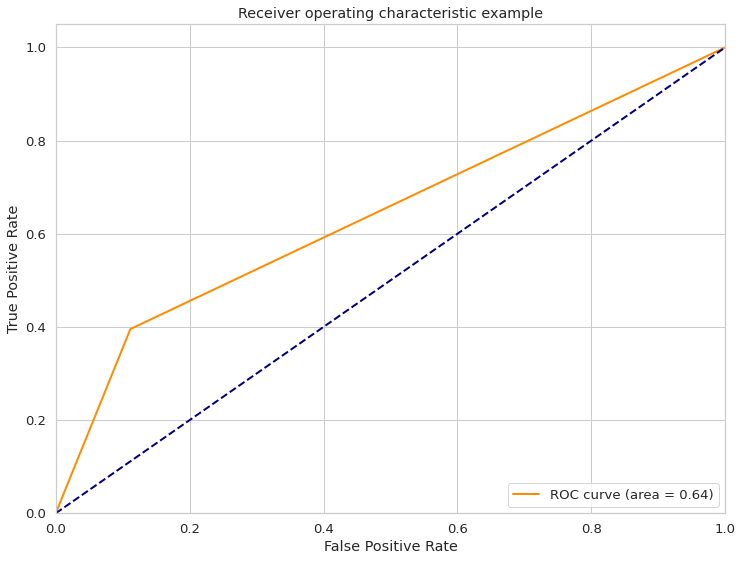

In [99]:
# For single class ROC plot,
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


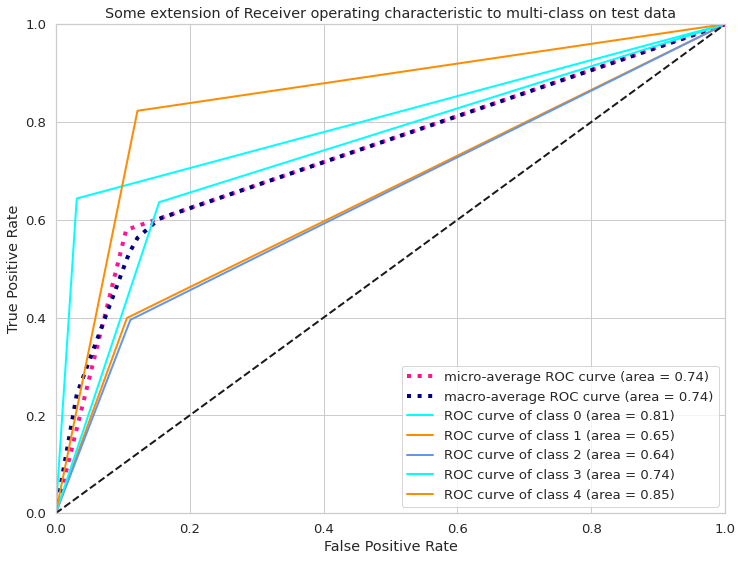

In [100]:
# For Multi-class ROC plot,
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class on test data')
plt.legend(loc="lower right")
plt.show()